# Basic Notebook

**the objective is to go through the first iteration very quickly**

## download the dataset

In [12]:
!pip install huggingface_hub --quiet

In [14]:
from huggingface_hub import snapshot_download
from pathlib import Path

raw_dataset_dir = Path("data/raw/")
interim_dataset_dir = Path("data/interim/")
processed_dataset_dir = Path("data/processed/")

snapshot_download(repo_id="Anuj-Panthri/Image-Colorization-Datasets",
                  repo_type="dataset",
                  local_dir=raw_dataset_dir)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

'/kaggle/working/data/raw'

## Prepare the dataset

In [19]:
# unzip data/raw/pascal-voc/trainval.zip & data/raw/pascal-voc/test.zip
# unzip to data/interim/
import os
from zipfile import ZipFile

# os.listdir()
with ZipFile(raw_dataset_dir/Path("pascal-voc/trainval.zip"),"r") as zip:
    zip.extractall(interim_dataset_dir/Path("trainval/"))
    
with ZipFile(raw_dataset_dir/Path("pascal-voc/test.zip"),"r") as zip:
    zip.extractall(interim_dataset_dir/Path("test/"))

In [20]:
# !rm -r {interim_dataset_dir}
!ls -lh {interim_dataset_dir}

total 1.1M
drwxr-xr-x 2 root root 532K May  4 03:16 test
drwxr-xr-x 2 root root 544K May  4 03:15 trainval


## Clean the dataset

In [24]:
import os
from glob import glob

trainval_dir = interim_dataset_dir / Path("trainval/")
test_dir = interim_dataset_dir / Path("test/")

trainval_paths = glob(str(trainval_dir/Path("*")))
test_paths = glob(str(test_dir/Path("*")))

len(trainval_paths),len(test_paths)

(17125, 16135)

is_bw: False


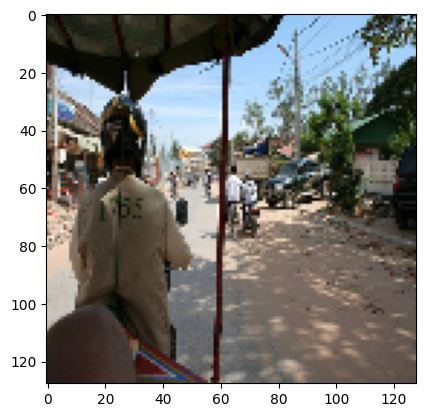

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def is_bw(img):
    rg,gb,rb = img[:,:,0]-img[:,:,1] , img[:,:,1]-img[:,:,2] , img[:,:,0]-img[:,:,2]
    rg,gb,rb = np.abs(rg).sum(),np.abs(gb).sum(),np.abs(rb).sum()
    avg = np.mean([rg,gb,rb])
#     print(rg,gb,rb)
    
    return avg<10
    
    
def show_img(img):
    plt.imshow(img)

img = cv2.imread(trainval_paths[0])[:,:,::-1]
img = cv2.resize(img,[128,128])
# img = np.c_[img[:,:,0:1],img[:,:,0:1],img[:,:,1:2]]
print("is_bw:",is_bw(img))
show_img(img)

In [54]:
from tqdm import tqdm

def get_bw_idxs(image_paths):
    bw_idxs = []
    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img,[128,128])
        if is_bw(img):
            bw_idxs.append(i)
    return bw_idxs

trainval_bw_idxs = get_bw_idxs(trainval_paths)
test_bw_idxs = get_bw_idxs(test_paths)
len(trainval_bw_idxs),len(test_bw_idxs)

100%|██████████| 16135/16135 [01:16<00:00, 211.07it/s]


375

In [55]:
len(trainval_bw_idxs),len(test_bw_idxs)

(375, 354)

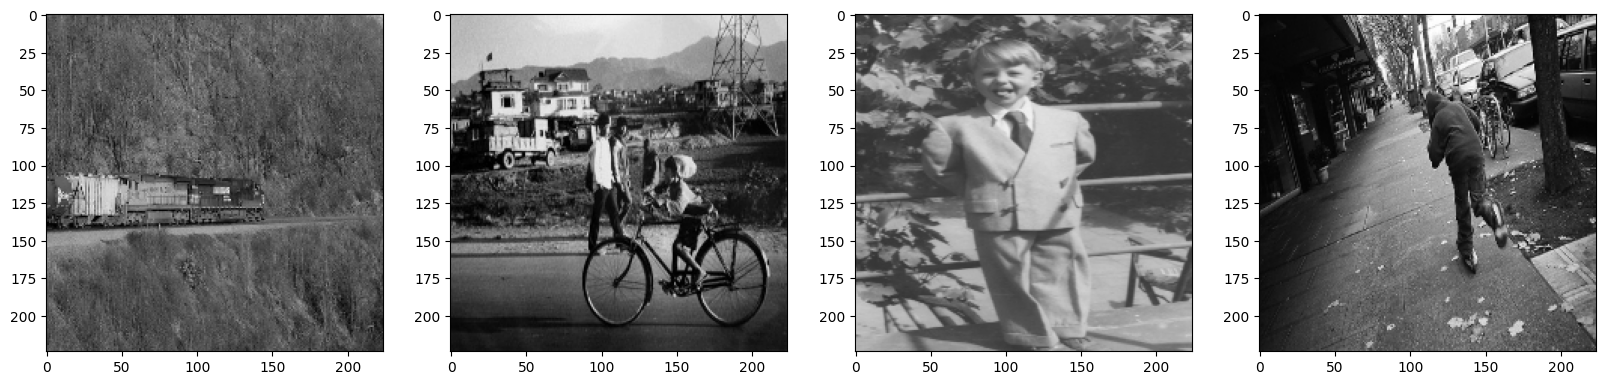

In [56]:
import math

n = 4
cols = 4
rows = math.ceil(n/cols)
fig = plt.figure(figsize=(5*cols,5*rows))
idxs = np.random.choice(trainval_bw_idxs,n)
for i in range(n):
    fig.add_subplot(rows,cols,i+1)
    img = cv2.imread(trainval_paths[idxs[i]])
    img = cv2.resize(img,[224,224])
    show_img(img)
plt.show() 

In [60]:
# copy the valid images to processed_dataset_dir
import shutil
import os

destination_dir = processed_dataset_dir/Path("trainval/")
if os.path.exists(destination_dir): shutil.rmtree(destination_dir)
os.makedirs(destination_dir)    
for i in tqdm(range(len(trainval_paths))):
    if i not in trainval_bw_idxs:
        shutil.copy(trainval_paths[i],
                    destination_dir)

destination_dir = processed_dataset_dir/Path("test/")
if os.path.exists(destination_dir): shutil.rmtree(destination_dir)
os.makedirs(destination_dir)
for i in tqdm(range(len(test_paths))):
    if i not in test_bw_idxs:
        shutil.copy(test_paths[i],
                    destination_dir)

100%|██████████| 16135/16135 [00:33<00:00, 484.89it/s] 


In [83]:
## clean old interim and raw datasets
import os
import shutil

shutil.rmtree(raw_dataset_dir)
shutil.rmtree(interim_dataset_dir)

## Load Dataset

In [61]:
trainval_dir = processed_dataset_dir / Path("trainval/")
test_dir = processed_dataset_dir / Path("test/")

trainval_paths = glob(str(trainval_dir/Path("*")))
test_paths = glob(str(test_dir/Path("*")))

len(trainval_paths),len(test_paths)

(16750, 15781)

In [67]:
import sklearn.model_selection


train_paths,val_paths = sklearn.model_selection.train_test_split(trainval_paths,
                                                                 train_size=0.8,
                                                                 random_state=324)
len(train_paths),len(val_paths)

(13400, 3350)

In [76]:
pip install -q tensorflow-io

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [93]:
import tensorflow as tf
import tensorflow_io as tfio

IMAGE_SIZE = 224

# load the image in lab space and split the l and ab channels
def load_img(img_path):
    img_bytes = tf.io.read_file(img_path)
    image = tf.image.decode_image(img_bytes,3,expand_animations=False)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image,[IMAGE_SIZE,IMAGE_SIZE])
    image = tfio.experimental.color.rgb_to_lab(image)
    return image[:,:,0:1],image[:,:,1:]
    
def get_ds(image_paths,bs=8,shuffle=False,is_val=False):
    ds = tf.data.Dataset.from_tensor_slices(image_paths)
    if shuffle:   ds = ds.shuffle(len(image_paths))
    ds = ds.map(load_img,num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(bs,num_parallel_calls=tf.data.AUTOTUNE,drop_remainder=not is_val)
    
    return ds

train_ds = get_ds(train_paths,shuffle=False)
L,AB = next(iter(train_ds))
L = L.numpy()
AB = AB.numpy()
print("L:",L.min(),L.max())
print("A:",AB[:,:,:,0].min(),AB[:,:,:,0].max())
print("B:",AB[:,:,:,1].min(),AB[:,:,:,1].max())

L: 0.0 100.0
A: -51.12508 78.89253
B: -57.875298 79.12992


In [94]:
train_ds.element_spec

(TensorSpec(shape=(8, 224, 224, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(8, 224, 224, 2), dtype=tf.float32, name=None))

## visualize the dataset

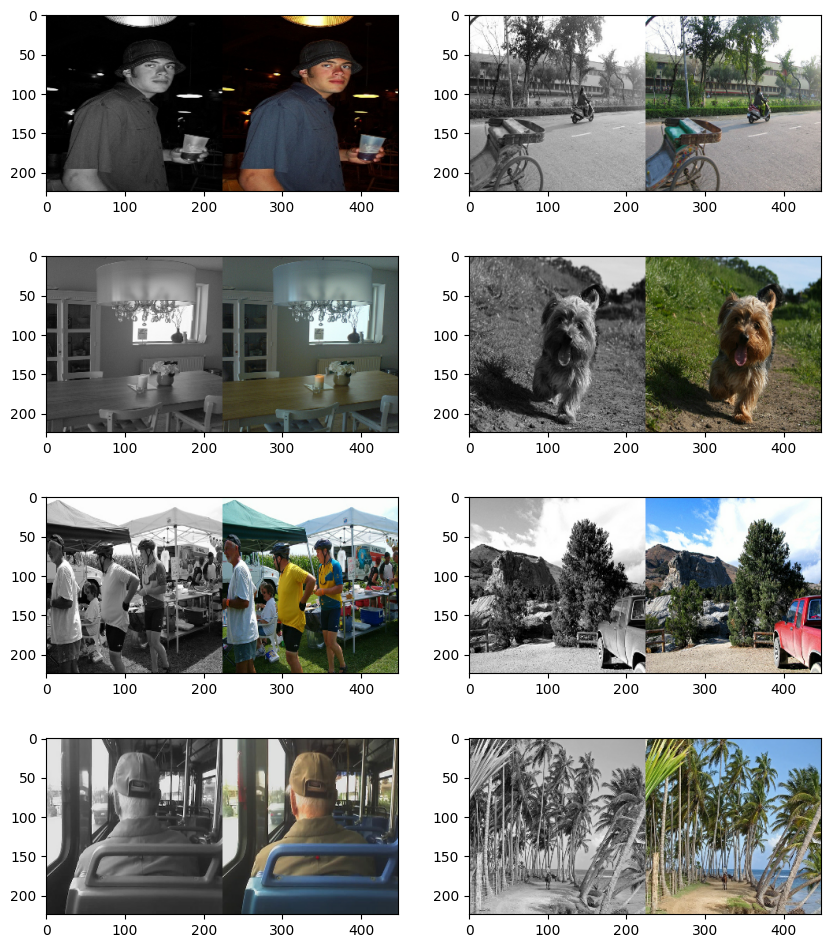

In [111]:
import math

def see_batch(L_batch,AB_batch,show_L=False,cols=4,row_size=5,col_size=5):
    n = L_batch.shape[0]
    rows = math.ceil(n/cols)
    fig = plt.figure(figsize=(col_size*cols,row_size*rows))
    for i in range(n):
        fig.add_subplot(rows,cols,i+1)
        L,AB = L_batch[i],AB_batch[i]
        img = np.concatenate([L,AB],axis=-1)
        img = cv2.cvtColor(img,cv2.COLOR_LAB2RGB)*255
#         print(img.min(),img.max())
        if show_L:
            L = np.tile(L,(1,1,3))/100*255
            img = np.concatenate([L,img],axis=1)
        show_img(img.astype("uint8"))
    plt.show()
    
L_batch,AB_batch = next(iter(train_ds))
L_batch,AB_batch = L_batch.numpy(), AB_batch.numpy()
# see_batch(L_batch,AB_batch)
see_batch(L_batch,AB_batch,show_L=True,cols=2,row_size=3,col_size=5)

## Define basic Model

## Define Metrics

## Train the Model

## See the results

## Evaluate on test set

## Save the model weights